# Datos del codigo:
* Estudiante: Juan Jose Valverde Campos
* Carnet: B47200
* Laboratorio 9 - K-means
* Profesor: Pablo Sauma Chacón

# 1. Importación de Librerías y asignación de directorios

In [96]:
# Importaciones
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import time
from PIL import Image
import os
# Directorio de imágenes
DIRECTORY = ["images/LotR/","images/RoseRed/","images/Shrek/"]

# 2. Método de carga load_image(filename, resize) 
Se encarga de cargar el archivo de imagen con nombre filename, cambia su tamaño al tamaño resize y la retorna como un arreglo multinivel de numpy.


In [97]:
def loader(path,total = 5,action='pad',gray=True,resize=None):
    if not os.path.exists(path):
        print("Invalid path")
        return None
    pimages = []
    minsize = None
    maxsize = None
    for i in range(1,total+1):
        pkmn = path+"/frame"+str(i)+".png"
        if not os.path.exists(pkmn):
            print("Failed to find",pkmn)
            continue
        pimages.append( Image.open(pkmn).convert('RGB') )
        minsize = min(pimages[-1].size[0], minsize) if minsize else pimages[-1].size[0]
        maxsize = max(pimages[-1].size[0], maxsize) if maxsize else pimages[-1].size[0]
    if action=='min':
        for i in range(len(pimages)):
            if pimages[i].size[0]==minsize: continue
            pimages[i] = pimages[i].resize((minsize,minsize), resample=Image.LANCZOS)
    elif action=='max':
        for i in range(len(pimages)):
            if pimages[i].size[0]==maxsize: continue
            pimages[i] = pimages[i].resize((maxsize,maxsize), resample=Image.NEAREST)
    elif action=='pad':
        for i in range(len(pimages)):
            if pimages[i].size[0]==maxsize: continue
            newimg = Image.new(pimages[i].mode, (maxsize, maxsize), (255, 255, 255))
            delta = (maxsize - pimages[i].size[0])//2
            newimg.paste(pimages[i], (delta, delta))
            pimages[i] = newimg
    images = []
    for i,pkmn in enumerate(pimages):
        if resize: pkmn = pkmn.resize(resize,Image.LANCZOS)
        image = np.array(pkmn, dtype=np.float32) / 255
        image = np.moveaxis(image, 2, 0)
        if gray:
            image = np.array([image.mean(axis=0)])
        images.append(image)    
    return np.array(images)
LotR = loader(DIRECTORY[0],total = 5,action='max',gray=False,resize=(255,255))
rosered = loader(DIRECTORY[1],total = 5,action='max',gray=False,resize=(255,255))
shrek = loader(DIRECTORY[2],total = 5,action='max',gray=False,resize=(255,255))

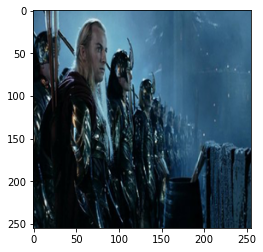

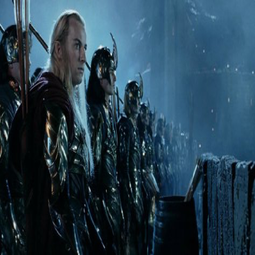

In [98]:
def plot_image(img,save=False,name=None,show=True):
  cmap =None
  data = (img*(255 if img.max()<=1 else 1)).transpose((1,2,0)).astype(np.uint8)
  plt.figure()
  plt.imshow(data,cmap=cmap)
  if show:
    plt.show()
  if save:
    if img.shape[0]==1:
      plt.imsave(name, data.squeeze(), cmap=cmap)
    else:
      plt.imsave(name, data, cmap=cmap)
  plt.close()
  return Image.fromarray(data.squeeze())
image = plot_image(LotR[3],save=False,name=None)
image

# 3. Método de cálculo de distancias euclidianas euclidean_distance(p1, p2) 
Recibe dos puntos p1 y p2, y retorna la distancia euclidiana entre ellos. Asuma que los puntos pueden ser n-dimensionales.


In [99]:
def euclidean_distance(p1, p2):
    pass

# 4. Método de cálculo de distancias de Manhattan manhattan_distance(p1, p2)
Recibe dos puntos p1 y p2, y retorna la distancia Manhattan entre ellos. La distancia Manhattan se calcula como la suma de las diferencias absolutas en cada una de las dimensiones para los puntos. Asuma que los puntos pueden ser n-dimensionales.

In [100]:
def manhattan_distance(p1, p2):
    pass

# 5. Método de selección de centroides nearest_centroid(point, centroids, distance) 
Recibe un punto point, la lista de centroides actuales centroids y una función distance(p1, p2) que calcula la distancia entre dos puntos. Esta función retorna una tupla (idx_centroid, distance) con el índice del centroide más cercano y su distancia respectiva.

**Nota**: Se debe implementar una función de manera que funcione en un problema en que los datos pueden tener n dimensiones, no necesariamente 3.


In [101]:
def nearest_centroid(point, centroids, distance):
    pass

# 6. Método lloyd(data, k, iters, type, distance) 
Recibe un conjunto de datos n-dimensionales data, un entero positivo k que especifica la cantidad de clusters en los que se desea agrupar la información, un entero positivo iters que especifica la cantidad de iteraciones del ciclo a ejecutar, una hilera type que puede ser “means” o “mediods” y una hilera distance que puede ser “euclidean” o “manhattan”. Debe implementar el algoritmo de Lloyd de manera que inicialice los puntos de manera aleatoria y luego ejecuta las iteraciones adecuadas del ciclo. Dependiendo del tipo deberá ejecutar el algoritmo como K-means o K-mediods, y deberá utilizar la función de distancia elegida por el usuario. Retorne los centroides obtenidos al final de la ejecución, así como el “error” total de dicho clustering (puede calcularlo como la suma de distancias o la suma de distancias cuadradas).

In [102]:
def error_function():
    pass

def lloyd(data, k, iters, type = "means", distance = "euclidean"):
    centroids = []
    distance_function = euclidean_distance if distance == "euclidean" else manhattan_distance
    if type == "means":
        for i in range(iters):
            pass
    else:
        for i in range(iters):
            pass
    error = error_function()
    return centroids,error

# 7. Calculo de paleta de colores de las imágenes
Saque los 5 colores principales que componen cada imagen. Extraiga la paleta de colores probando con las 4 mezclas generadas por nuestro algoritmo: means/mediods con euclidean/manhattan para comprobar las variaciones que esto puede generar. Dado que la inicialización aleatoria puede llevar a soluciones locales, ejecute cada experimento 3 veces y tome los centroides de la solución con menor error. Finalmente para cada una de las imágenes, guarde una muestra de la imagen al lado de las 4 paletas de colores extraídas por los algoritmos. Para ello puede usar matplotlib o algún programa de imágenes.

Recomendaciones generales
* Trabajar con imágenes muy grandes resulta computacionalmente costoso, por lo que puede reducir sus imágenes a tamaños más manejables por medio del resize incluido en el método de carga. Sin embargo, si la reduce mucho se pierde mucha información por lo que se le recomienda no reducir la imagen abajo de 128x128.

* Recuerde que las imágenes son tratadas como tipo de dato uint8, sin embargo esto genera errores de redondeo a la hora de hacer cálculos computacionales. Por lo que se le recomienda convertir sus tipos de datos a flotante.


In [109]:
np.random.seed(2)
np.random.rand()

0.43599490214200376

0.025926231827891333

# 8. Imágenes finales
Entregue junto con su código ejecutable todas las imágenes obtenidas.

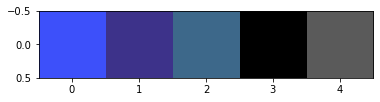

In [84]:
def plott_image(colors):
  cmap =None
  data = colors
  plt.figure()
  plt.imshow(data,cmap=cmap)
  plt.show()
  plt.close()
  return Image.fromarray(data.squeeze())
colors = np.array([[[61,80,250],[61,50,138],[61,104,138],[0,0,0],[90,90,90]]]).astype(np.uint8)
image = plott_image(colors)
image # Falta